In [2]:
# link Colab virtual environment with Google Drive in order to conveniently read data from it or write data to it
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# link Colab virtual environment with Google Drive in order to conveniently read data from it or write data to it
!mkdir -p drive 
!google-drive-ocamlfuse -o nonempty drive

In [4]:
ls

adc.json  drive/  sample_data/


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from statsmodels.tsa import stattools
import os
import time
import pickle
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.externals.joblib import dump,load
# from google.colab import files

Step 1: Load data from Google Drive, do basic analysis of the data quality and generate train & trade set for each study period

In [0]:
# def retrieve_adj_close_price_data(directory="./historical_data/"):
#     """
#     Retrieve daily adj close prices of all SP500 index constituent stocks and concatenate them into a DataFrame object
#     """
#     adj_price_list=[]
#     for filename in os.listdir(directory):
#         if filename[-4:] != ".csv":
#             continue
#         adj_close=pd.read_csv(directory+filename,index_col="Date",parse_dates=True)[["Adj Close"]]
#         adj_close.columns=pd.Index([filename.split("+")[0]])
#         adj_price_list.append(adj_close)
#     return pd.concat(adj_price_list,axis=1,join='outer')
# 
# adj_close_price=retrieve_adj_close_price_data()

In [0]:
# def simple_net_return_in_n_day_period(close_price,n_periods=1):
#     """
#     Calculate simple net return in a n-day period with formula R(t,n)=(P(t)-P(t-n))/P(t-n), i.e. from daily adj close price
#     """
#     simple_return=close_price.diff(n_periods)/close_price.shift(n_periods)
#     return simple_return[n_periods:]
# 
# daily_return=simple_net_return_in_n_day_period(adj_close_price,1)

def simple_net_return_in_n_day_period(daily_return,n_periods=1):
    """
    Calculate simple net return in a n-day period with formula R(t,n)=(1+R(t,1))*(1+R(t-1,1))*...*(1+R(t-n+1,1))-1, i.e. from daily simple net return
    Input: daily_return - a DataFrame object
    """
    for i in range(n_periods):
        if i==0:
            simple_return=daily_return+1  # simple gross return
        else:
            simple_return=simple_return*(daily_return.shift(i)+1)
            
    return simple_return-1  # simple net return

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Stock 200273100 with the smallest non-missing value, count = 21.


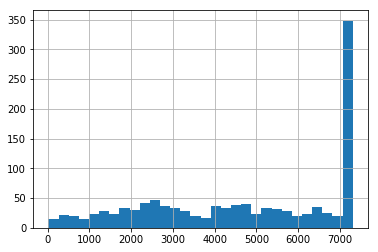

In [8]:
# load preprocessed data (daily return, a DataFrame object) from linked Google Drive
orig_data_directory="./drive/Paper Replication/Paper_1/historical_data/"
daily_return=pickle.load(open(orig_data_directory+"daily_return","rb"))

# use func read_csv()'s date parsing utility to parse the string-format date in the first column and set it as the index column
daily_return.to_csv(orig_data_directory+"daily_return_temp")
daily_return=pd.read_csv(orig_data_directory+"daily_return_temp",index_col="date",parse_dates=True)
os.remove(orig_data_directory+"daily_return_temp")

# count and plot the number of non-missing value of every stock's daily return series during all study periods
daily_return.describe().loc["count"].hist(bins=30)

# display the CUSIP of stock with smallest non-missing value
cusip=np.argmin(daily_return.describe().loc["count"])
count=int(np.min(daily_return.describe().loc["count"]))
print("Stock {} with the smallest non-missing value, count = {}.".format(cusip,count))

In [9]:
daily_return.head()

,000886309,00101J106,001055102,001204106,00130H105,001547108,001957505,00206R102,00209A106,002824100,...,G97822103,G98294104,H1467J104,H27178104,H2906T109,H84989104,H8817H100,N53745100,N59465109,V7780T103
date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.013605,NaN,-0.020833,-0.032922,NaN,NaN,0.021978,0.013699,NaN,0.018382,...,NaN,NaN,NaN,0.060241,NaN,NaN,NaN,NaN,-0.020619,NaN
1990-01-03,-0.006711,NaN,-0.021277,0.000000,NaN,NaN,-0.008065,-0.017375,NaN,0.003610,...,NaN,NaN,NaN,-0.011364,NaN,NaN,NaN,NaN,-0.036842,NaN
1990-01-04,-0.020270,NaN,-0.021739,-0.017021,NaN,NaN,-0.016260,-0.025147,NaN,-0.001799,...,NaN,NaN,NaN,-0.022989,NaN,NaN,NaN,NaN,-0.010929,NaN
1990-01-05,0.006897,NaN,0.000000,0.012987,NaN,NaN,-0.016529,-0.034623,NaN,-0.010811,...,NaN,NaN,NaN,-0.011765,NaN,NaN,NaN,NaN,0.000000,NaN
1990-01-08,-0.013699,NaN,0.014815,0.012821,NaN,NaN,0.025210,0.016878,NaN,0.005100,...,NaN,NaN,NaN,0.005952,NaN,NaN,NaN,NaN,0.011050,NaN


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


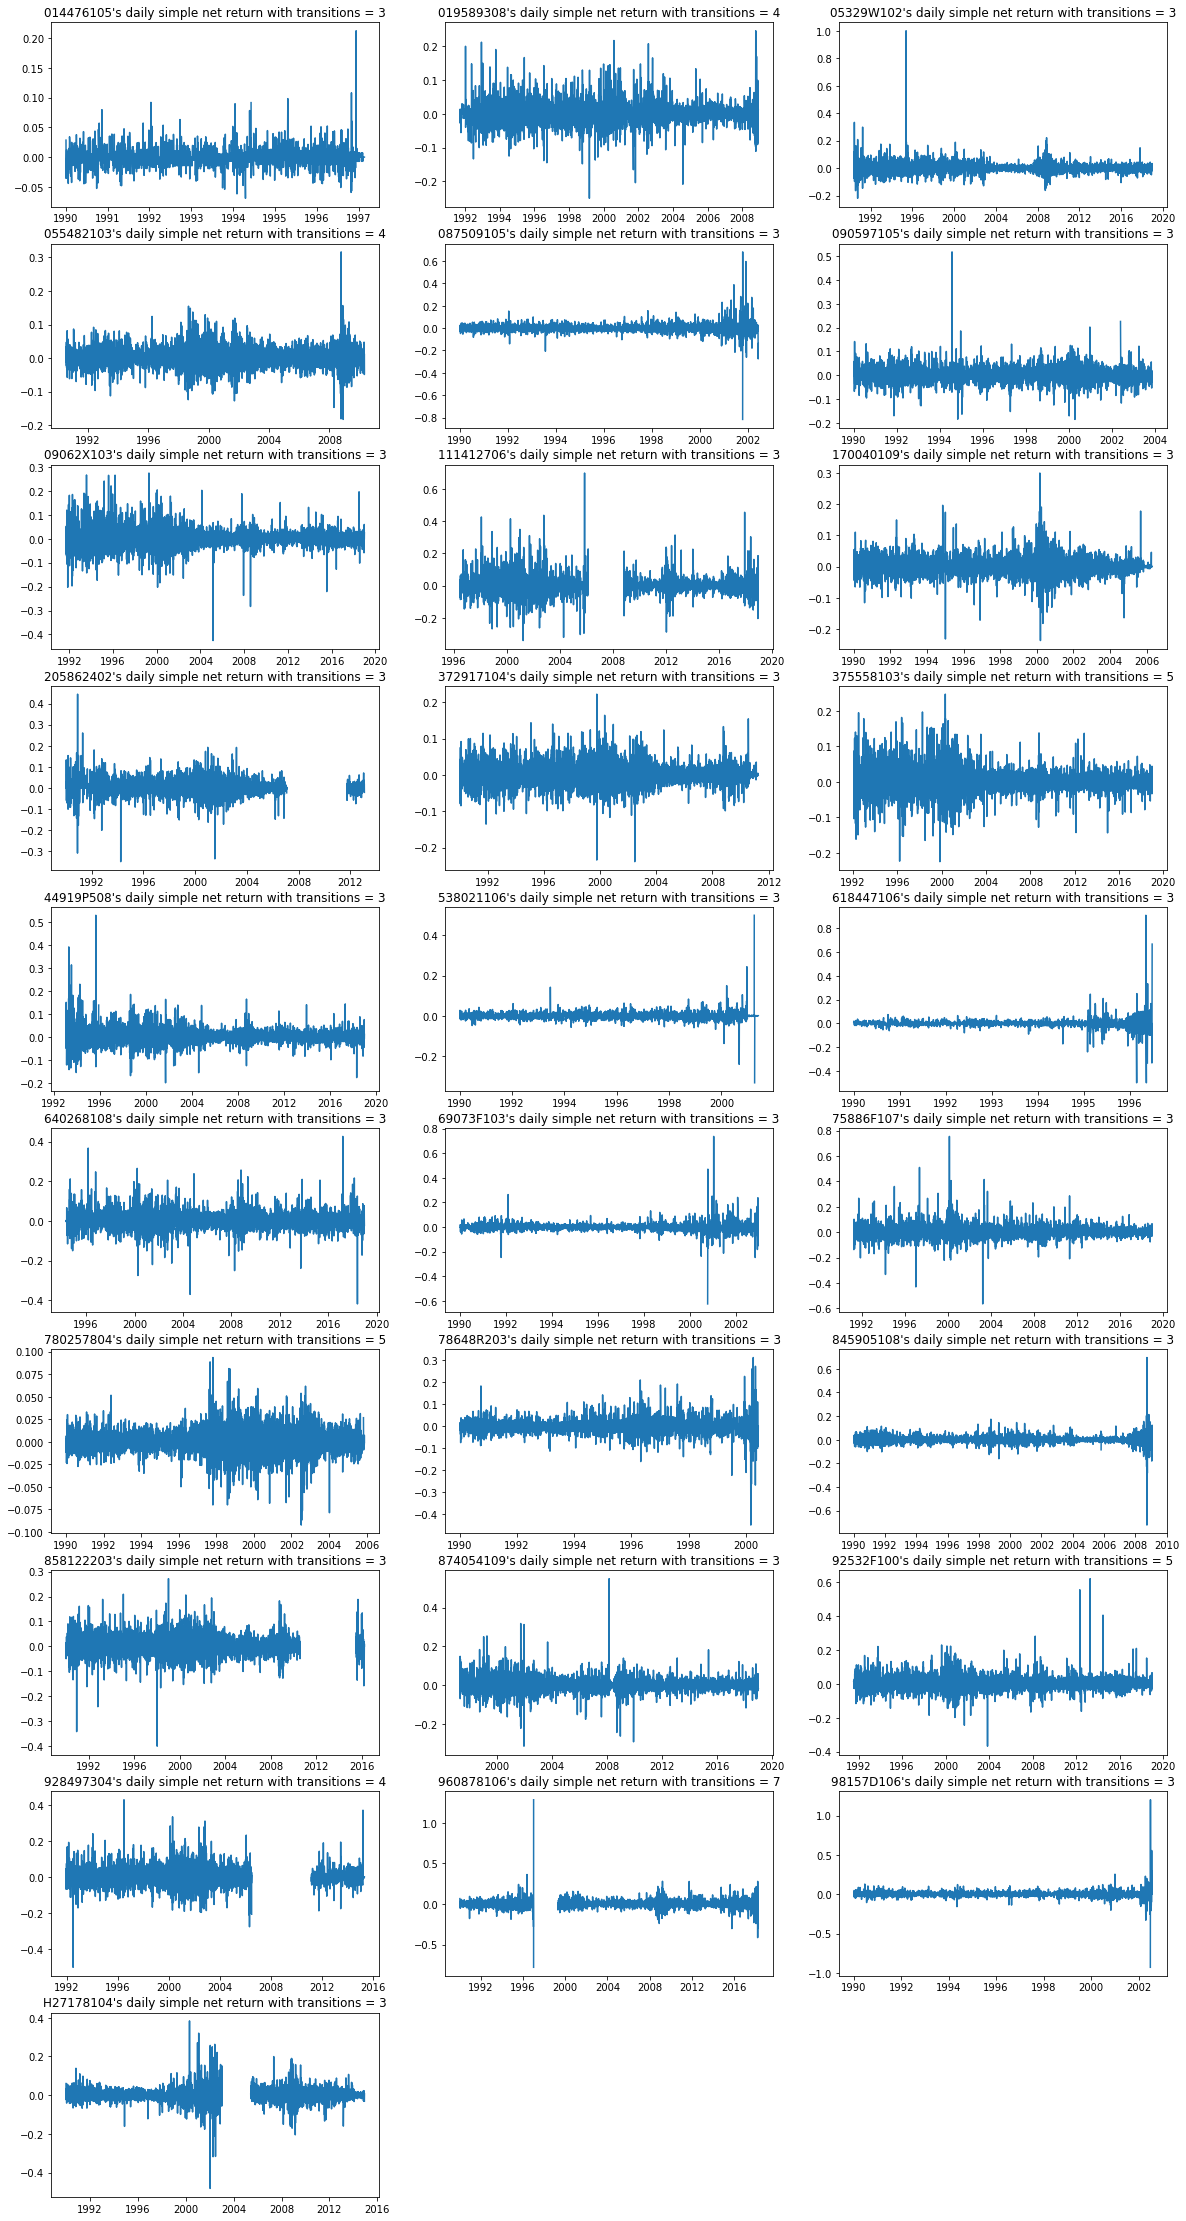

In [10]:
def abnormal_series_detection(daily_return):
    """
    Detect abnormal stock daily return series, using the number of transitions from missing value (i.e. np.nan) to non-missing value or the reverse, since 
    the normal transition number should be 0 (i.e. a stock listed since the start of study period), 1 (i.e a stock listed at start but then delisted OR a 
    stock not listed at start but then listed) or 2 (i.e a stock not listed at start but then listed and finally delisted; note that the other possibility 
    belongs to abnormal situation, i.e. a stock listed at start but then delisted and finally listed again). And abnormal return series with more than 2 
    transitions may be related with trading halt or other situations.
    """
    # count the number of transitions defined above and list the stocks having more than 2 transitions
    abnormal=daily_return.isna().astype(np.int32).diff(1)[1:].abs().sum(axis=0)  # a Series with length = stock_num
    abnormal_stocks=list(abnormal[abnormal>=3].index)
    
    # plot the daily return series of stocks having more than 2 transitions
    num_rows=len(abnormal_stocks)//3+1
    plt.figure(figsize=(20,num_rows*4))
    for i,stock in enumerate(abnormal_stocks):
        plt.subplot(num_rows,3,i+1)
        plt.plot(daily_return[stock])
        plt.title("{}'s daily simple net return with transitions = {}".format(stock,int(abnormal[stock])))

abnormal_series_detection(daily_return)

In [0]:
# def generate_sample_constituent_stock_matrix(daily_return_m):
#     """
#     Generate sample SP500 constituent stock binary matrix with element (i,j) denoting whether the j-th stock belongs
#     to SP500 index at i-th month end (0=False, 1=True) before obtaining the actual constituent stock matrix
#     """
#     start=str(daily_return_m.index[0].year)+"-"+str(daily_return_m.index[0].month)
#     end=str(daily_return_m.index[-1].year)+"-"+str(daily_return_m.index[-1].month)
#     date_idx=pd.date_range(start,end,freq="M")
#     stock_ticker=daily_return_m.columns
#     return pd.DataFrame(np.ones((len(date_idx),len(stock_ticker)),np.int16),index=date_idx,columns=stock_ticker)
# 
# stock_consti=generate_sample_constituent_stock_matrix(daily_return)

# load preprocessed data (SP500 constituent stock, a DataFrame object) from linked Google Drive
stock_consti=pickle.load(open(orig_data_directory+"stock_consti","rb"))

# use func read_csv()'s date parsing utility to parse the string-format date in the first column and set it as the index column
stock_consti.to_csv(orig_data_directory+"stock_consti_temp")
stock_consti=pd.read_csv(orig_data_directory+"stock_consti_temp",index_col=0,parse_dates=True)
os.remove(orig_data_directory+"stock_consti_temp")

In [16]:
stock_consti.head()

,000886309,00101J106,001055102,001204106,00130H105,001547108,001957505,00206R102,00209A106,002824100,...,G97822103,G98294104,H1467J104,H27178104,H2906T109,H84989104,H8817H100,N53745100,N59465109,V7780T103
1989-12-31,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-01-31,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-02-28,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-03-31,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1990-04-30,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
def calculate_num_study_periods(total_days,train_period,trade_period):
    """
    Calculate the number of study periods given total available days, train period and trade period length
    """
    return (total_days-train_period)//trade_period

train_period=750
trade_period=250
sequence_length=240
num_study_period=calculate_num_study_periods(len(daily_return.index),train_period,trade_period)
print("The number of study periods is {}.".format(num_study_period))

The number of study periods is 26


In [0]:
def shift_one_month_ahead(time_point):
    """
    Shift the timestamp to the previous month's ending
    """
    return pd.Timestamp(str(time_point.year)+"-"+str(time_point.month)+"-"+"01",freq="M")-pd.Timedelta(1,"D")

In [0]:
def generate_target_value(input_array):
    """
    Generate target value for input array with those stocks the return of which is larger than the market median level set to positive value and the other 
    stocks the return of which is smaller than the market median level set to negative value at each current timestep
    """
    input_array[:,:,-1]=input_array[:,:,-1]-np.nanmedian(input_array[:,:,-1],axis=1,keepdims=True)
    return input_array

In [0]:
def exclude_missing_value(input_array):
    """
    Exclude missing value (including missing return information at pervious timesteps or missing target value) and flatten 3-D array with shape 
    (num_timesteps, num_stocks, sequence_len) into 2-D array with shape (num_instances, sequence_len)
    """
    # generate a binary matrix denoting the position of no-missing-value sequences (True = no missing value)
    nan_matrix=(np.sum(np.isnan(input_array),axis=2)==0)
    
    # calculate and print the ratio of sequences with missing value in all constructed sequences
    nan_ratio=100-np.sum(nan_matrix)/(nan_matrix.shape[0]*nan_matrix.shape[1])*100
    print("There are {:.2f}% sequences having missing value in all constructed sequences!".format(nan_ratio))
    
    # only select no-missing-value sequences and flatten them into a 2-D array
    exclude_nan=input_array[nan_matrix]
    
    return exclude_nan,nan_matrix

In [0]:
def generate_train_trade_set_each_study_period(return_m,stock_m,train_period,trade_period,sequence_len,study_period_idx,save_directory):
    """
    Generate train and trade set for LSTM RNN of given study period and save them together with other useful information for later analysis 
    temporarily on Colab virtual machine disk
    """
    # obtain the up-to-date (previous month end) list of SP500 constituent stocks at the last day of train period
    train_period_end_idx=study_period_idx*trade_period+train_period-1  # the index of train period end
    train_period_end_date=return_m.index[train_period_end_idx]  # the date of train period end
    train_period_end_prev_month=shift_one_month_ahead(train_period_end_date)  # the date of previous month end
    stock_list=stock_m.iloc[stock_m.index.get_loc(train_period_end_prev_month)] # a Series with length = stock_num_avail
    
    # obtain the return series of SP500 constituent stocks (may have slight diff to reality) in this study period
    start_idx=study_period_idx*trade_period  # the index of study period start
    end_idx=(study_period_idx+1)*trade_period+train_period  # the index of study period end
    return_sp500=return_m[stock_list[stock_list==1].index].iloc[start_idx:end_idx]
    return_column=return_sp500.columns  # the list of stocks' cusip (an Index object)
        
    # standardize return series using train period's mean return and stdev (excluding missing value)
    return_train_array=return_sp500.iloc[:train_period].values
    miu=np.nanmean(return_train_array)  # mean
    sigma=np.nanstd(return_train_array)  # stdv
    return_std=(return_sp500-miu)/sigma
    
    # transform return series from DataFrame to Ndarray and add the timesteps dimension (axis=2)
    return_array=return_std.values
    return_add_dims=np.expand_dims(return_array,axis=2)
    
    # construct train and trade set with return information at pervious "sequence_len" timesteps
    shifted_list=[return_add_dims]  # the target value (before transforming into binary value)
    for t in range(sequence_len):
        # the feature sequence (note: you can only use last day's available return information to predict today's return)
        shifted_list.append(np.roll(return_add_dims,shift=t+1,axis=0))
    shifted_list_r=list(reversed(shifted_list))  # to put target value at bottom
    return_concat=np.concatenate(shifted_list_r,axis=2)
    return_train_set=return_concat[sequence_len:train_period,:,:]
    return_trade_set=return_concat[train_period:,:,:]
        
    # generate target value (positive when outperform median level and negative when underperform median level)
    return_train_set_label=generate_target_value(return_train_set)
    return_trade_set_label=generate_target_value(return_trade_set)
    
    # print(return_train_set_label[:,:,-1])
    # print(return_trade_set_label[:,:,-1])
    
    # exclude sequences with missing value and flatten them from a 3-D array into a 2-D array
    return_train_set_nonan,_=exclude_missing_value(return_train_set_label)
    return_trade_set_nonan,nonan_identifier=exclude_missing_value(return_trade_set_label)  
    
    # separate features (X) and target (Y) and transform target into binary value (1 = positive, 0 = negative)
    return_train_set_X=return_train_set_nonan[:,:-1]  # train set feature sequence with shape (num_instances_1,sequence_len)
    return_train_set_Y=(return_train_set_nonan[:,-1]>=0).astype(np.int32)  # train set target value with shape (num_instances_1)
    return_trade_set_X=return_trade_set_nonan[:,:-1]  # trade set feature sequence with shape (num_instances_2,sequence_len)
    return_trade_set_Y=(return_trade_set_nonan[:,-1]>=0).astype(np.int32)  # trade set target value with shape (num_instances_2)
     
    # save train & trade set, non-nan identifier of trade set, list of constituent stocks, miu & sigma of return in train period
    pickle.dump(return_train_set_X,open(save_directory+"/return_train_X_"+str(study_period_idx),"wb"))
    pickle.dump(return_train_set_Y,open(save_directory+"/return_train_Y_"+str(study_period_idx),"wb"))
    pickle.dump(return_trade_set_X,open(save_directory+"/return_trade_X_"+str(study_period_idx),"wb"))
    pickle.dump(return_trade_set_Y,open(save_directory+"/return_trade_Y_"+str(study_period_idx),"wb"))
    pickle.dump(nonan_identifier,open(save_directory+"/nonan-identifier_for_trade_"+str(study_period_idx),"wb"))
    pickle.dump(return_column,open(save_directory+"/stock_list_in_sp500_index_"+str(study_period_idx),"wb"))
    pickle.dump((miu,sigma),open(save_directory+"/return_miu_sigma_"+str(study_period_idx),"wb"))

In [0]:
def generate_train_trade_set_each_study_period_benchmark(return_m,stock_m,train_period,trade_period,study_period_idx,save_directory):
    """
    Generate train and trade set for benchmark models (i.e. DNN, random forest, logistic regression) of given study period and save them together 
    with other useful information for later analysis temporarily on Colab virtual machine disk   
    """
    # obtain the up-to-date (previous month end) list of SP500 constituent stocks at the last day of train period
    train_period_end_idx=study_period_idx*trade_period+train_period-1  # the index of train period end
    train_period_end_date=return_m.index[train_period_end_idx]  # the date of train period end
    train_period_end_prev_month=shift_one_month_ahead(train_period_end_date)  # the date of previous month end
    stock_list=stock_m.iloc[stock_m.index.get_loc(train_period_end_prev_month)] # a Series with length = stock_num_avail
    
    # obtain the return series of SP500 constituent stocks (may have slight diff to reality) in this study period
    start_idx=study_period_idx*trade_period  # the index of study period start
    end_idx=(study_period_idx+1)*trade_period+train_period  # the index of study period end
    return_sp500=return_m[stock_list[stock_list==1].index].iloc[start_idx:end_idx]
    return_column=return_sp500.columns  # the list of stocks' cusip (an Index object)
    
    """
    # calculate n-period returns to construct input features
    return_list=[simple_net_return_in_n_day_period(return_sp500,1)]
    for n_periods in list(np.linspace(1,20,20))+list(np.linspace(40,240,11)):
        return_n_period=simple_net_return_in_n_day_period(return_sp500,int(n_periods))
        return_list.append(return_n_period.shift(1,axis=0))
    return_frame=pd.concat(list(reversed(return_list)),axis=1,join="outer")
    
    # construct train and trade set with n_period return information at pervious timesteps    
    num_stock=np.sum(stock_list==1)
    shifted_list=[]
    for idx in range(len(return_frame.columns)//num_stock):
        return_array=return_frame.iloc[:,idx*num_stock:(idx+1)*num_stock].values
        # standardize return series using train set's mean return and stdev
        miu=np.nanmean(return_array[:train_period])
        sigma=np.nanstd(return_array[:train_period])
        return_std=np.expand_dims((return_array-miu)/sigma,axis=2)
        shifted_list.append(return_std)
    return_concat=np.concatenate(shifted_list,axis=2)
    return_train_set=return_concat[240:train_period,:,:]
    return_trade_set=return_concat[train_period:,:,:]
    """
    
    # construct train and trade set with n_period return information at pervious timestep (i.e. last day)
    # generate the target value (no need for standardization) in a 3-D array form
    return_list=[np.expand_dims(simple_net_return_in_n_day_period(return_sp500,1).values,axis=2)]
    # generate the feature sequence (need for standardization) in a 3-D array form
    for n_periods in list(np.linspace(1,20,20))+list(np.linspace(40,240,11)):
        # calculate n-period return to construct input feature
        return_n_period=simple_net_return_in_n_day_period(return_sp500,int(n_periods))  # a DataFrame
        # shift 1 period forward becasue you can only use last day's return information to predict today's return
        return_array=return_n_period.shift(1,axis=0).values  # a 2-D array
        # standardize return series using its corresponding mean and stdev in train period
        miu=np.nanmean(return_array[:train_period])
        sigma=np.nanstd(return_array[:train_period])
        return_std=np.expand_dims((return_array-miu)/sigma,axis=2)
        return_list.append(return_std)
    return_concat=np.concatenate(list(reversed(return_list)),axis=2)
    return_train_set=return_concat[240:train_period,:,:]
    return_trade_set=return_concat[train_period:,:,:]
    
    # generate target value (positive when outperform median level and negative when underperform median level)
    return_train_set_label=generate_target_value(return_train_set)
    return_trade_set_label=generate_target_value(return_trade_set)
    
    # print(return_train_set_label[:,:,-1])
    # print(return_trade_set_label[:,:,-1])
    
    # exclude sequences with missing value and flatten them from a 3-D array into a 2-D array
    return_train_set_nonan,_=exclude_missing_value(return_train_set_label)
    return_trade_set_nonan,nonan_identifier=exclude_missing_value(return_trade_set_label)  

    # separate features (X) and target (Y) and transform target into binary value (1 = positive, 0 = negative)
    return_train_set_X=return_train_set_nonan[:,:-1]  # train set feature sequence with shape (num_instances_1,sequence_len)
    return_train_set_Y=(return_train_set_nonan[:,-1]>=0).astype(np.int32)  # train set target value with shape (num_instances_1)
    return_trade_set_X=return_trade_set_nonan[:,:-1]  # trade set feature sequence with shape (num_instances_2,sequence_len)
    return_trade_set_Y=(return_trade_set_nonan[:,-1]>=0).astype(np.int32)  # trade set target value with shape (num_instances_2)
     
    # save train & trade set, non-nan identifier of trade set, list of constituent stocks
    pickle.dump(return_train_set_X,open(save_directory+"/return_train_X_"+str(study_period_idx),"wb"))
    pickle.dump(return_train_set_Y,open(save_directory+"/return_train_Y_"+str(study_period_idx),"wb"))
    pickle.dump(return_trade_set_X,open(save_directory+"/return_trade_X_"+str(study_period_idx),"wb"))
    pickle.dump(return_trade_set_Y,open(save_directory+"/return_trade_Y_"+str(study_period_idx),"wb"))
    pickle.dump(return_column,open(save_directory+"/stock_list_in_sp500_index_"+str(study_period_idx),"wb"))
    pickle.dump(nonan_identifier,open(save_directory+"/nonan-identifier_for_trade_"+str(study_period_idx),"wb"))

In [18]:
data_directory_rnn="./train_trade_set/LSTM_RNN"
os.makedirs(data_directory_rnn,exist_ok=True)

tic=time.time()

# generate train and trade set of LSTM RNN for all study periods and save them temporarily on Colab virtual machine disk
for i in range(num_study_period):
    print("Generating train and trade set of LSTM RNN for {}-th study period...".format(i))
    generate_train_trade_set_each_study_period(daily_return,stock_consti,train_period,trade_period,sequence_length,i,data_directory_rnn)
    
tac=time.time()
print("The time of running this code block is {:.2f} minutes!".format((tac-tic)/60))

Generating train and trade set of LSTM RNN for 0-th study period...
There are 4.32% missing values in constructed sequences!
There are 4.00% missing values in constructed sequences!
Generating train and trade set of LSTM RNN for 1-th study period...
There are 3.77% missing values in constructed sequences!
There are 4.05% missing values in constructed sequences!
Generating train and trade set of LSTM RNN for 2-th study period...
There are 4.53% missing values in constructed sequences!
There are 4.74% missing values in constructed sequences!
Generating train and trade set of LSTM RNN for 3-th study period...
There are 4.52% missing values in constructed sequences!
There are 4.73% missing values in constructed sequences!
Generating train and trade set of LSTM RNN for 4-th study period...
There are 4.52% missing values in constructed sequences!
There are 4.70% missing values in constructed sequences!
Generating train and trade set of LSTM RNN for 5-th study period...
There are 4.13% missin

In [34]:
data_directory_dnn="./train_trade_set/benchmark"
os.makedirs(data_directory_dnn,exist_ok=True)

tic=time.time()

# generate train and trade set of benchmark models for all study periods and save them temporarily on Colab virtual machine disk
for i in range(num_study_period):
    print("Generating train and trade set of benchmark models for {}-th study period...".format(i))
    generate_train_trade_set_each_study_period_benchmark(daily_return,stock_consti,train_period,trade_period,i,data_directory_dnn)
    
tac=time.time()
print("The time of running this code block is {:.2f} minutes!".format((tac-tic)/60))

Generating train and trade set of benchmark models for 0-th study period...
There are 4.32% missing values in constructed sequences!
There are 4.00% missing values in constructed sequences!
Generating train and trade set of benchmark models for 1-th study period...
There are 3.77% missing values in constructed sequences!
There are 4.05% missing values in constructed sequences!
Generating train and trade set of benchmark models for 2-th study period...
There are 4.53% missing values in constructed sequences!
There are 4.74% missing values in constructed sequences!
Generating train and trade set of benchmark models for 3-th study period...
There are 4.52% missing values in constructed sequences!
There are 4.73% missing values in constructed sequences!
Generating train and trade set of benchmark models for 4-th study period...
There are 4.52% missing values in constructed sequences!
There are 4.70% missing values in constructed sequences!
Generating train and trade set of benchmark models

Step 2: Construct and train different types of models and then use trained models to make predictions on trade set as well as generate 2k portfolio and corresponding realized return

In [0]:
def construct_rnn_model(sequence_length):
    """
    Construct RNN with LSTM cell using Keras
    """
    X_input=keras.layers.Input(shape=(sequence_length,1))  # the input layer
    X=keras.layers.CuDNNLSTM(25)(X_input)  # using 25 as the number of hidden units in LSTM cell based on paper authors' choice
    X=keras.layers.Dropout(0.1)(X)  # using 0.1 as the dropout ratio in dropout layer based on paper authors' choice
    X=keras.layers.Dense(1,activation="sigmoid")(X)  
    # since it's a binary classification problem, using an output layer with one unit and sigmoid activation function is equivalent to using an output 
    # layer with two units and softmax activation function
    model=keras.models.Model(inputs=X_input,outputs=X)
    return model

In [0]:
def lstm_rnn(train_X,train_Y,trade_X,trade_Y,sequence_len,study_period_idx,to_directory):
    """
    Construct, compile, train(fit) LSTM RNN model and then use it make out-of-sample predictions
    """
    # clear session to avoid bug in multiple runs of the model using the same default session
    keras.backend.clear_session()  
    
    # construct LSTM RNN model
    model=construct_rnn_model(sequence_len)
    
    # compile LSTM RNN model
    model.compile(optimizer=keras.optimizers.Adam(0.001),loss=keras.losses.binary_crossentropy,metrics=["accuracy"])
    # 1) the paper authors don't report the learning rate they used to train the model, so I just use 0.001 (however, learning rate is a key hyperparameter
    # in determining the performance of trained model, and a better method may be using random or grid search to find the learning rate that minimize the
    # loss on validation set); 2) the paper authors use RMSprop as the training algorithm, but nowadays, Adam algorithm seems to be a better choice.
    
    # fit(train) LSTM RNN model
    model.fit(train_X,train_Y,batch_size=1000,epochs=1000,verbose=0,validation_split=0.2,callbacks=
              [keras.callbacks.EarlyStopping("val_loss",patience=50,restore_best_weights=True),keras.callbacks.
               ModelCheckpoint(to_directory+"/study-"+str(study_period_idx)+"weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                               monitor="val_loss",save_best_only=True)])
    # 1) the paper authors don't report the batch size of mini-batch train set they used to train the model, so I just use 1000 since it's not a hyper-
    # parameter having a huge influence on the performance of trained model; 2) the paper author use 10 as the value of patience used in early stopping,
    # but here I use 50 since better value won't hurt the traning result but can sometimes improve it; 3) the choices of other hyperparameters are all
    # based on the paper authors' settings.
    
    # evaluate LSTM RNN model (return loss and accuracy on trade set)
    model.evaluate(trade_X,trade_Y)
    
    # generate probability predictions of trade set
    pred_prob=model.predict(trade_X)
    
    return pred_prob

In [0]:
def construct_dnn_model(layer_dims):
    """
    Construct DNN given the number of units in each layer using Keras
    """
    # the input layer
    X_input=keras.layers.Input(shape=(layer_dims[0],))
    
    # the first hidden layer
    X=keras.layers.Dense(layer_dims[1],activation="relu",kernel_regularizer=keras.regularizers.l1(0.00001))(X_input)
    X=keras.layers.Dropout(0.5)(X)
    
    # the second hidden layer
    X=keras.layers.Dense(layer_dims[2],activation="relu",kernel_regularizer=keras.regularizers.l1(0.00001))(X)
    X=keras.layers.Dropout(0.5)(X)
    
    # the third hidden layer
    X=keras.layers.Dense(layer_dims[3],activation="relu",kernel_regularizer=keras.regularizers.l1(0.00001))(X)
    X=keras.layers.Dropout(0.5)(X) 
    
    # the output layer
    X=keras.layers.Dense(layer_dims[4],activation=None,kernel_regularizer=keras.regularizers.l1(0.00001))(X)
    # 1) using 0.00001 as the coefficient of l1 regularization term in cost function based on paper authors' choice
    # 2) using 0.5 as the dropout ratio in dropout layer based on paper authors' choice
    
    model=keras.models.Model(inputs=X_input,outputs=X)
    
    return model

In [0]:
def dnn(train_X,train_Y,trade_X,trade_Y,study_period_idx,to_directory):
    """
    Construct, compile, train(fit) DNN model and then use it make out-of-sample predictions
    """
    # clear session to avoid bug in multiple runs of the model using the same default session
    keras.backend.clear_session()
    
    # construct DNN model
    model=construct_dnn_model([31,31,10,5,1])
    
    # compile DNN model
    model.compile(optimizer=keras.optimizers.Adam(0.001),loss=keras.losses.binary_crossentropy,metrics=["accuracy"])
    # 1) the paper authors don't report the learning rate they used to train the model, so I just use 0.001 (however, learning rate is a key hyperparameter
    # in determining the performance of trained model, and a better method may be using random or grid search to find the learning rate that minimize the
    # loss on validation set); 2) the paper authors use RMSprop as the training algorithm, but nowadays, Adam algorithm seems to be a better choice.
    
    # fit(train) DNN model
    model.fit(train_X,train_Y,batch_size=1000,epochs=1000,verbose=0,validation_split=0.2,callbacks=
              [keras.callbacks.EarlyStopping("val_loss",patience=50,restore_best_weights=True),keras.callbacks.
               ModelCheckpoint(to_directory+"/study-"+str(study_period_idx)+"weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                               monitor="val_loss",save_best_only=True)])
    # 1) the paper authors don't report the batch size of mini-batch train set they used to train the model, so I just use 1000 since it's not a hyper-
    # parameter having a huge influence on the performance of trained model; 2) the paper author use 10 as the value of patience used in early stopping,
    # but here I use 50 since better value won't hurt the traning result but can sometimes improve it; 3) the choices of other hyperparameters are all
    # based on the paper authors' settings.
    
    # evaluate DNN model (return loss and accuracy on trade set)
    model.evaluate(trade_X,trade_Y)
    
    # generate probability predictions of trade set
    pred_prob=model.predict(trade_X)
    
    return pred_prob

In [0]:
def random_forest(train_X,train_Y,trade_X,study_period_idx,to_directory):
    """
    Construct, train(fit) random forest and then use it to make out-of-sample predictions
    """
    rf_clf=RandomForestClassifier(n_estimators=1000,max_depth=20,bootstrap=True)  # all hyperparameters are based on paper's choice
    rf_clf.fit(train_X,train_Y)
    pred_prob=rf_clf.predict_proba(trade_X)[:,1]
    
    # save model
    dump(rf_clf,to_directory+"/study-"+str(study_period_idx))
    
    return pred_prob

In [0]:
def logistic_regression(train_X,train_Y,trade_X,study_period_idx,to_directory):
    """
    Construct, train(fit) logistic regression and then use it to make out-of-sample predictions
    """
    log_reg=LogisticRegression(penalty="l2",solver="lbfgs",max_iter=100)  # all hyperparameters are based on paper's choice
    
    # use grid search to find the best value of C (the coefficient of l2 regularization term in cost function)
    param_grid={"C":list(np.power(10,np.linspace(-4,4,101)))}
    grid_search=GridSearchCV(log_reg,param_grid,cv=5,scoring='neg_mean_squared_error')
    grid_search.fit(train_X,train_Y)
    
    pred_prob=grid_search.best_estimator_.predict_proba(trade_X)[:,1]
    
    # save model
    dump(grid_search.best_estimator_,to_directory+"/study-"+str(study_period_idx))
    
    return pred_prob

In [0]:
def construct_the_2k_portfolio(pred_prob_frame,k):
    """
    Construct the 2k portfolio by longing k stocks with highest predicted probability to outperform the market and shorting k stocks with lowest 
    predicted probability to outperform the market
    """
    portfolio=[]
    top_k_idx_1,top_k_idx_2=[],[]  # records the row and column position index of top-k stocks in pred_prob_frame
    flop_k_idx_1,flop_k_idx_2=[],[]  # records the row and column position index of flop-k stocks in pred_prob_frame
    
    for i in range(len(pred_prob_frame.index)):
        
        # count the number of avaiable stocks at date i
        count_nonan=np.sum(1-pred_prob_frame.iloc[i].isna().astype(np.int16))
        # generate warning information if there aren't enough avaiable stocks at date i
        if count_nonan>=2*k:
            warning=""
        elif (count_nonan<2*k) & (count_nonan>=k):
            warning="k<=nonan<2k"
            # print("Warning: not enough available stocks at date {}, k<=nonan<2k".format(pred_prob_frame.index[i]))
        else:
            warning="nonan<k"
            # print("Serious Warning: not enough available stocks at date {}, nonan<k".format(pred_prob_frame.index[i]))
        
        
        # generate the list of top-k stocks at each date and their position index in pred_prob_frame
        pred_prob_temp=pred_prob_frame.sort_values(by=pred_prob_frame.index[i],axis=1,inplace=False,na_position="first")
        top_k=list(pred_prob_temp.columns[-k:])
        for cusip in top_k:
            top_k_idx_1.append(i)
            top_k_idx_2.append(pred_prob_frame.columns.get_loc(cusip))    
        
        # generate the list of flop-k stocks at each date and their position index in pred_prob_frame
        pred_prob_temp=pred_prob_frame.sort_values(by=pred_prob_frame.index[i],axis=1,inplace=False,na_position="last")
        flop_k=list(pred_prob_temp.columns[:k])
        for cusip in flop_k:
            flop_k_idx_1.append(i)
            flop_k_idx_2.append(pred_prob_frame.columns.get_loc(cusip))
            
        portfolio.append({"top_k":top_k,"flop_k":flop_k,"warning":warning})
        
    return portfolio,(top_k_idx_1,top_k_idx_2),(flop_k_idx_1,flop_k_idx_2)

In [0]:
def obtain_the_realized_return(portfolio,daily_return):
    """
    Calculate the realized daily return of 2-k portfolio (with equal weights)
    """

#     for i in range(len(portfolio)):
#         # note that the i-th date in adj_close is one day earlier of the i-th date in daily_return
#         price_long=adj_close.iloc[i][portfolio[i]["top_k"]].sum()
#         price_short=adj_close.iloc[i][portfolio[i]["flop_k"]].sum()
#         weights_long=adj_close.iloc[i][portfolio[i]["top_k"]]/(price_long-price_short)
#         rtn_from_long=(daily_return.iloc[i][portfolio[i]["top_k"]]*weights_long).sum()
#         weights_short=-adj_close.iloc[i][portfolio[i]["flop_k"]]/(price_long-price_short)
#         rtn_from_short=(daily_return.iloc[i][portfolio[i]["flop_k"]]*weights_short).sum()
#         total_rtn=rtn_from_long+rtn_from_short
#         if ((price_long-price_short<=0) & (total_rtn>0)) | ((price_long-price_short<0) & (total_rtn>=0)):
#             portfolio[i]["arbitrage"]="Yes"
#         portfolio[i]["return"]=total_rtn
#     return portfolio
  
    for i in range(len(portfolio)):
        
        # the realized daily return of top-k stocks with equal weights
        rtn_from_long=daily_return.iloc[i][portfolio[i]["top_k"]].mean()
        portfolio[i]["return_long"]=rtn_from_long
        
        # the realized daily return of flop-k stocks with equal weights        
        rtn_from_short=-daily_return.iloc[i][portfolio[i]["flop_k"]].mean()
        portfolio[i]["return_short"]=rtn_from_short
        
    return portfolio

In [0]:
def generate_portfolio_and_return(daily_return,study_period_idx,sequence_len,model_type,from_directory,to_directory):
    
    # retrieve train and trade set for current study period
    train_X=pickle.load(open(from_directory+"/return_train_X_"+str(study_period_idx),"rb"))
    train_Y=pickle.load(open(from_directory+"/return_train_Y_"+str(study_period_idx),"rb"))
    trade_X=pickle.load(open(from_directory+"/return_trade_X_"+str(study_period_idx),"rb"))
    trade_Y=pickle.load(open(from_directory+"/return_trade_Y_"+str(study_period_idx),"rb"))
    
    # retrieve non-nan identifier for trade set
    nonan_idf=pickle.load(open(from_directory+"/nonan-identifier_for_trade_"+str(study_period_idx),
                               "rb")).astype(np.float64)
    
    # retrieve the list of SP500 index constituent stock for current study period
    stock_list=pickle.load(open(from_directory+"/stock_list_in_sp500_index_"+str(study_period_idx),"rb"))
    
    # train and use the specified model to generate probability predictions on trade set
    if model_type == "RNN":
        train_X=np.expand_dims(train_X,axis=2)
        train_Y=np.expand_dims(train_Y,axis=2)
        trade_X=np.expand_dims(trade_X,axis=2)
        trade_Y=np.expand_dims(trade_Y,axis=2)        
        pred_prob=lstm_rnn(train_X,train_Y,trade_X,trade_Y,sequence_len,study_period_idx,to_directory)
    
    elif model_type == "DNN":
        pred_prob=dnn(train_X,train_Y,trade_X,trade_Y,study_period_idx,to_directory)
    
    elif model_type == "RAF":
        pred_prob=random_forest(train_X,train_Y,trade_X,study_period_idx,to_directory)
    
    elif model_type == "LOG":
        pred_prob=logistic_regression(train_X,train_Y,trade_X,study_period_idx,to_directory)
    
    else:
        print("Model type must belong to ['RNN','DNN','RAF','LOG']!")
        return None
    
    # using non-nan identifier to transform predicted target value from ndarray with shape (num_instances,1) into DataFrame with shape (trade_period,
    # num_stocks) and nan value denoting unavailable stocks (i.e. no target value) or unavailable predictions (i.e incomplete feature sequence, thus
    # can't make predictions)
    pred_prob_with_nan=np.copy(nonan_idf)
    pred_prob_with_nan[pred_prob_with_nan==0]=np.nan
    pred_prob_with_nan[pred_prob_with_nan==1]=pred_prob.reshape(-1)
    pred_prob_frame=pd.DataFrame(pred_prob_with_nan,index=daily_return.index,columns=stock_list)
    
    # using non-nan identifier to transform input feature sequences from ndarray with shape (num_instances,sequence_len,1) into ndarray with shape 
    # (trade_period,num_stocks,sequence_len) and nan value denoting unavailable stocks (i.e. no target value) or unavailable predictions 
    # (i.e incomplete feature sequence, thus can't make predictions)
    if model_type == "RNN":
        nonan_idf_3d=np.concatenate([np.expand_dims(nonan_idf,axis=2)]*sequence_len,axis=2)
        trade_X_with_nan=np.copy(nonan_idf_3d)
        trade_X_with_nan[trade_X_with_nan[:,:,0]==1]=trade_X[:,:,0]  # the shape of trade_X is (num_instances,sequence_len,1)
    
    # generate 2-k portfolio for each day in trade period
    portfolio_dict={}
    for k in [10,50,100,150,200]:
        portfolio,top_k_idx,flop_k_idx=construct_the_2k_portfolio(pred_prob_frame,k)
        # extract the past return sequences of each stock in 2-k portfolio
        if (model_type == "RNN") & (k == 10):
            miu,sigma=pickle.load(open(from_directory+"/return_miu_sigma_"+str(study_period_idx),"rb"))
            top_10_seq=trade_X_with_nan[top_k_idx[0],top_k_idx[1],:]*sigma+miu  # the shape of top_10_seq is (trade_period*k,sequence_len)
            flop_10_seq=trade_X_with_nan[flop_k_idx[0],flop_k_idx[1],:]*sigma+miu  # the shape of flop_10_seq is (trade_period*k,sequence_len)
        # calculate the realized daily return of 2-k portfolio at each date
        portfolio=obtain_the_realized_return(portfolio,daily_return)
        portfolio_dict[k]=portfolio
    
    if model_type == "RNN":
        return portfolio_dict,top_10_seq,flop_10_seq
    else:
        return portfolio_dict

In [28]:
model_directory_rnn="./model_weights/recurrent_neural_network"
os.makedirs(model_directory_rnn,exist_ok=True)

tic=time.time()

portfolio_list_rnn=[]  # to record the 2-k portfolio for each study period and each k choice and each date in the corresponding trade period
top_k_seq_list=[]  # to record the past return sequences of each stock ever in top-k portfolio (only when k=10) for each study period
flop_k_seq_list=[]  # to record the past return sequences of each stock ever in flop-k portfolio (only when k=10) for each study period

# generate the daily 2k portfolio and corresponding realized return of LSTM RNN for each study period
for i in range(num_study_period):
    print("Generating the daily 2k portfolio and corresponding realized returns of LSTM RNN for {}-th study period...".format(i))
    trade_start=i*trade_period+train_period
    trade_end=(i+1)*trade_period+train_period
    portfolio_dict,top_k_seq,flop_k_seq=generate_portfolio_and_return(daily_return.iloc[trade_start:trade_end],i,sequence_length,"RNN",
                                                                      data_directory_rnn,model_directory_rnn)
    portfolio_list_rnn.append(portfolio_dict)
    top_k_seq_list.append(top_k_seq)
    flop_k_seq_list.append(flop_k_seq)
    
top_k_seq_array=np.concatenate(top_k_seq_list,axis=0)
flop_k_seq_array=np.concatenate(flop_k_seq_list,axis=0)

tac=time.time()
print("The time of running this code block is {:.2f} hours!".format((tac-tic)/3600))

Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 0-th study period...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Instructions for updating:
Use tf.cast instead.
116644/116644 [==============================] - 24s 203us/sample - loss: 0.6904 - acc: 0.5326
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 1-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


116584/116584 [==============================] - 23s 200us/sample - loss: 0.6905 - acc: 0.5313
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 2-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


116218/116218 [==============================] - 24s 210us/sample - loss: 0.6901 - acc: 0.5336
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 3-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


115993/115993 [==============================] - 23s 200us/sample - loss: 0.6922 - acc: 0.5226
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 4-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


116265/116265 [==============================] - 23s 202us/sample - loss: 0.6913 - acc: 0.5244
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 5-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


116521/116521 [==============================] - 23s 199us/sample - loss: 0.6941 - acc: 0.5099
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 6-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


116023/116023 [==============================] - 24s 203us/sample - loss: 0.6926 - acc: 0.5104
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 7-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


116831/116831 [==============================] - 25s 218us/sample - loss: 0.6918 - acc: 0.5180
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 8-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


115825/115825 [==============================] - 25s 214us/sample - loss: 0.6938 - acc: 0.5110
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 9-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


118108/118108 [==============================] - 24s 206us/sample - loss: 0.6935 - acc: 0.5058
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 10-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


119403/119403 [==============================] - 25s 206us/sample - loss: 0.6932 - acc: 0.5038
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 11-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


119918/119918 [==============================] - 26s 216us/sample - loss: 0.6932 - acc: 0.5076
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 12-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


119755/119755 [==============================] - 26s 218us/sample - loss: 0.6930 - acc: 0.5045
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 13-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


117744/117744 [==============================] - 24s 201us/sample - loss: 0.6929 - acc: 0.5064
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 14-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


116836/116836 [==============================] - 25s 217us/sample - loss: 0.6935 - acc: 0.5045
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 15-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


118800/118800 [==============================] - 26s 216us/sample - loss: 0.6934 - acc: 0.5124
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 16-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


118289/118289 [==============================] - 25s 211us/sample - loss: 0.6935 - acc: 0.5022
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 17-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


119925/119925 [==============================] - 24s 201us/sample - loss: 0.6932 - acc: 0.4989
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 18-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


120745/120745 [==============================] - 25s 211us/sample - loss: 0.6930 - acc: 0.5057
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 19-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


121085/121085 [==============================] - 26s 212us/sample - loss: 0.6932 - acc: 0.4978
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 20-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


120577/120577 [==============================] - 25s 211us/sample - loss: 0.6931 - acc: 0.5037
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 21-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


121056/121056 [==============================] - 24s 201us/sample - loss: 0.6929 - acc: 0.5085
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 22-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


121062/121062 [==============================] - 25s 203us/sample - loss: 0.6932 - acc: 0.5044
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 23-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


119679/119679 [==============================] - 24s 201us/sample - loss: 0.6932 - acc: 0.5075
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 24-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


122899/122899 [==============================] - 26s 211us/sample - loss: 0.6931 - acc: 0.5059
Generating the daily 2k portfolio and corresponding returns of LSTM RNN for 25-th study period...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


123820/123820 [==============================] - 25s 201us/sample - loss: 0.6934 - acc: 0.5033
The time of running this code block is 3.00 hours!


In [0]:
results_directory_rnn="./drive/Paper Replication/Paper_1/analysis_results/LSTM_RNN_results"
os.makedirs(results_directory_rnn,exist_ok=True)

# save the 2k portfolio and corresponding information to linked Google Drive
pickle.dump(portfolio_list_rnn,open(results_directory_rnn+"/portfolio","wb"))
pickle.dump(top_k_seq_array,open(results_directory_rnn+"/top_k_seq","wb"))
pickle.dump(flop_k_seq_array,open(results_directory_rnn+"/flop_k_seq","wb"))

# for filename in os.listdir(results_directory_rnn):
#     files.download(results_directory_rnn+"/"+filename)  # it seems that you can't put multiple files.download() into one code block

In [0]:
# for filename in os.listdir(model_directory_rnn):
#     files.download(model_directory_rnn+"/"+filename)

In [0]:
model_directory_dnn="./model_weights/deep_neural_network"
os.makedirs(model_directory_dnn,exist_ok=True)

tic=time.time()

portfolio_list_dnn=[]  # to record the 2-k portfolio for each study period and each k choice and each date in the corresponding trade period

# generate the daily 2k portfolio and corresponding realized return of DNN for each study period
for i in range(num_study_period):
    print("Generating the daily 2k portfolio and corresponding realized returns of deep neural network for {}-th study period...".format(i))
    trade_start=i*trade_period+train_period
    trade_end=(i+1)*trade_period+train_period
    portfolio_dict=generate_portfolio_and_return(daily_return.iloc[trade_start:trade_end],i,sequence_length,"DNN",data_directory_dnn,model_directory_dnn)
    portfolio_list_dnn.append(portfolio_dict)
    
tac=time.time()
print("The time of running this code block is {:.2f} hours!".format((tac-tic)/3600))

Generating the daily 2k portfolio and corresponding realized returns of deep neural network for 0-th study period...
116644/116644 [==============================] - 6s 54us/sample - loss: 0.6915 - acc: 0.5268
Generating the daily 2k portfolio and corresponding realized returns of deep neural network for 1-th study period...
116584/116584 [==============================] - 6s 54us/sample - loss: 0.6918 - acc: 0.5226
Generating the daily 2k portfolio and corresponding realized returns of deep neural network for 2-th study period...
116218/116218 [==============================] - 7s 59us/sample - loss: 0.6912 - acc: 0.5346
Generating the daily 2k portfolio and corresponding realized returns of deep neural network for 3-th study period...
115993/115993 [==============================] - 6s 54us/sample - loss: 0.6922 - acc: 0.5214
Generating the daily 2k portfolio and corresponding realized returns of deep neural network for 4-th study period...
116265/116265 [============================

In [0]:
results_directory_dnn="./drive/Paper Replication/Paper_1/analysis_results/DNN_results"
os.makedirs(results_directory_dnn,exist_ok=True)

# save the 2k portfolio and corresponding information to linked Google Drive
pickle.dump(portfolio_list_dnn,open(results_directory_dnn+"/portfolio","wb"))

# for filename in os.listdir(results_directory_dnn):
#     files.download(results_directory_dnn+"/"+filename)

In [0]:
# for filename in os.listdir(model_directory_dnn):
#     files.download(model_directory_dnn+"/"+filename)

In [0]:
data_directory_raf="./train_trade_set/benchmark"
model_directory_raf="./model_weights/random_forest"
os.makedirs(model_directory_raf,exist_ok=True)

tic=time.time()

portfolio_list_raf=[]  # to record the 2-k portfolio for each study period and each k choice and each date in the corresponding trade period

# generate the daily 2k portfolio and corresponding realized return of random forest for each study period
for i in range(num_study_period):
    print("Generating the daily 2k portfolio and corresponding realized returns of random forest for {}-th study period...".format(i))
    trade_start=i*trade_period+train_period
    trade_end=(i+1)*trade_period+train_period
    portfolio_dict=generate_portfolio_and_return(daily_return.iloc[trade_start:trade_end],i,sequence_length,"RAF",data_directory_raf,model_directory_raf)
    portfolio_list_raf.append(portfolio_dict)
    
tac=time.time()
print("The time of running this code block is {:.2f} hours!".format((tac-tic)/3600))

In [0]:
results_directory_raf="./drive/Paper Replication/Paper_1/analysis_results/RAF_results"
os.makedirs(results_directory_raf,exist_ok=True)

# save the 2k portfolio and corresponding information to linked Google Drive
pickle.dump(portfolio_list_raf,open(results_directory_raf+"/portfolio","wb"))

# for filename in os.listdir(results_directory_raf):
#     files.download(results_directory_raf+"/"+filename)

In [0]:
# for filename in os.listdir(model_directory_raf):
#     files.download(model_directory_raf+"/"+filename)

In [0]:
data_directory_log="./train_trade_set/benchmark"
model_directory_log="./model_weights/logistic_regression"
os.makedirs(model_directory_log,exist_ok=True)

tic=time.time()

portfolio_list_log=[]  # to record the 2-k portfolio for each study period and each k choice and each date in the corresponding trade period

# generate the daily 2k portfolio and corresponding realized return of logistic regression for each study period
for i in range(num_study_period):
    print("Generating the daily 2k portfolio and corresponding realized returns of logistic regression for {}-th study period...".format(i))
    trade_start=i*trade_period+train_period
    trade_end=(i+1)*trade_period+train_period
    portfolio_dict=generate_portfolio_and_return(daily_return.iloc[trade_start:trade_end],i,sequence_length,"LOG",data_directory_log,model_directory_log)
    portfolio_list_log.append(portfolio_dict)
    
tac=time.time()
print("The time of running this code block is {:.2f} hours!".format((tac-tic)/3600))

In [0]:
results_directory_log="./drive/Paper Replication/Paper_1/analysis_results/LOG_results"
os.makedirs(results_directory_log,exist_ok=True)

# save the 2k portfolio and corresponding information to linked Google Drive
pickle.dump(portfolio_list_log,open(results_directory_log+"/portfolio","wb"))

# for filename in os.listdir(results_directory_log):
#     files.download(results_directory_log+"/"+filename)

In [0]:
# for filename in os.listdir(model_directory_log):
#     files.download(model_directory_log+"/"+filename)

Step 3: Do analysis on generated 2k portfolio (from each trained model's predictions)

In [0]:
# load the 2k portfolio and corresponding information from linked Google Drive
portfolio_list_rnn=pickle.load(open(results_directory_rnn+"/portfolio","rb"))
portfolio_list_dnn=pickle.load(open(results_directory_dnn+"/portfolio","rb"))
portfolio_list_raf=pickle.load(open(results_directory_raf+"/portfolio","rb"))
portfolio_list_log=pickle.load(open(results_directory_log+"/portfolio","rb"))

# load the past return sequences of each stock ever in top-k and flop-k portfolio
top_k_seq=pickle.load(open(results_directory_rnn+"/top_k_seq","rb"))
flop_k_seq=pickle.load(open(results_directory_rnn+"/flop_k_seq","rb"))

In [0]:
def construct_analysis_tables(portfolio_list,daily_return,train_period,trade_period):
    """
    Construct a dict of DataFrames containing formatted information (e.x. "flop_k", "top_k", "return_short", "return_long", "warning", "study_period") 
    that can facilitate afterwards analysis. The structure of it is: {k_1:DataFrame_1,k_2:DataFrame_2,...}.
    
    """
    analysis_tables={}
    
    for k in portfolio_list[0].keys():  # 0 denotes the first study period
        analysis_tables[k]=[]
    
    # swap the hierarchic level of k(k_1,k_2,...) and study period(idx_1,idx_2,...)
    for idx,portfolio_i_period in enumerate(portfolio_list):
        for k,portfolio_list in portfolio_i_period.items():
            start=idx*trade_period+train_period
            end=(idx+1)*trade_period+train_period
            # transform a dict into DataFrame with the keys of dict become column labels of DataFrame
            portfolio_frame=pd.DataFrame(portfolio_list,index=daily_return.index[start:end])
            # add an additional column to record the study period that each entry belongs to
            portfolio_column=pd.DataFrame([idx]*(end-start),index=daily_return.index[start:end],columns=["Study period"])
            # concate the additional column to the DataFrame mentioned above
            analysis_tables[k].append(pd.concat([portfolio_frame,portfolio_column],axis=1))
            
    # concate the each value (a list of DataFrames for each study period) of analysis_tables (a dict) into a single DataFrame     
    for k,portfolio_list in analysis_tables.items():
        analysis_tables[k]=pd.concat(portfolio_list,axis=0)
        
    return analysis_tables

analysis_table_dict={} # structure: {model_1:{k_1:DataFrame_1,k_2:DataFrame_2,...},model_2:{k_1:DataFrame_a,k_2:DataFrame_b,...},...}
analysis_table_rnn=construct_analysis_tables(portfolio_list_rnn,daily_return,train_period,trade_period)
analysis_table_dict["RNN"]=analysis_table_rnn
analysis_table_dnn=construct_analysis_tables(portfolio_list_dnn,daily_return,train_period,trade_period)
analysis_table_dict["DNN"]=analysis_table_dnn
analysis_table_raf=construct_analysis_tables(portfolio_list_raf,daily_return,train_period,trade_period)
analysis_table_dict["RAF"]=analysis_table_raf
analysis_table_log=construct_analysis_tables(portfolio_list_log,daily_return,train_period,trade_period)
analysis_table_dict["LOG"]=analysis_table_log

In [0]:
analysis_table_dict["RNN"][10].head()  # an example

,flop_k,return_long,return_short,top_k,warning,Study period
Date,,,,,,
1992-12-18,"[SIG, INTC, LOW, MSI, SWK, MRO, HRB, AFL, VZ, ...",0.011952,0.011802,"[IP, F, PHM, BBY, MMM, NOC, IBM, CSCO, PKI, COO]",nonan>=2k,0
1992-12-21,"[INTC, LOW, LUV, BBT, UNH, DWDP, C, EA, CELG, ...",0.017792,-0.000993,"[ROST, LH, FISV, STT, TAP, COO, EXPD, BBY, SWK...",nonan>=2k,0
1992-12-22,"[SIG, INTC, LUV, BBT, EA, SWK, SYY, LOW, VZ, DVN]",0.009975,0.012445,"[PRGO, CERN, WMT, CDNS, AMAT, APH, LH, IBM, ST...",nonan>=2k,0
1992-12-23,"[COO, EA, INTC, XRAY, HBAN, LUV, PBCT, SWKS, S...",0.060798,-0.001629,"[DRE, IBM, ORCL, CERN, BBY, APH, OMC, GLW, BII...",nonan>=2k,0
1992-12-24,"[HBAN, COO, ORCL, EA, BA, SIG, XRAY, PBCT, APH...",0.007088,0.012021,"[K, REGN, CERN, EXPD, BMY, MNST, CELG, GLW, IP...",nonan>=2k,0
1992-12-28,"[HBAN, APH, HOLX, BA, WDC, USB, COO, DE, RTN, ...",-0.003511,-0.001332,"[VFC, SYY, REGN, BDX, CERN, UNH, K, GLW, SWKS,...",nonan>=2k,0
1992-12-29,"[APH, WDC, USB, HOLX, MNST, COG, DE, LEG, BA, ...",0.011226,0.000070,"[EIX, CELG, HRB, CERN, LRCX, OXY, UNH, PBCT, S...",nonan>=2k,0
1992-12-30,"[WDC, LEG, DE, USB, EA, IPG, MNST, PKI, TIF, BK]",-0.006157,0.011215,"[SO, CPB, PBCT, DRE, VRTX, DUK, PSA, BBY, MMM,...",nonan>=2k,0
1992-12-31,"[TIF, DE, LEG, EA, ROST, VNO, ZION, OMC, JWN, ...",-0.004439,0.003646,"[INTC, EXC, PPL, APH, MNST, HOLX, VRTX, PBCT, ...",nonan>=2k,0


The overall performance comparison of different models on 2k portfolio with different size k

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


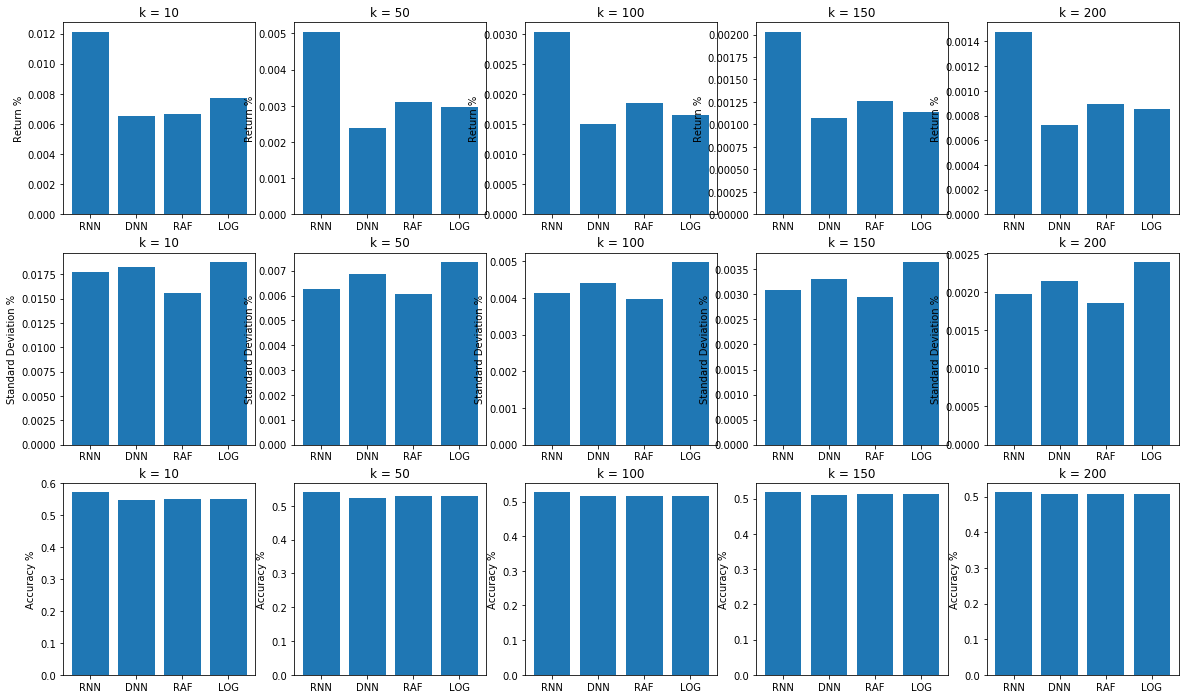

In [0]:
def analysis_model_performance(analysis_table_dict,daily_return,return_series=False):
    """
    Conduct the overall performance comparison of different models on 2k portfolio with different sizes, in terms of the mean and standard deviation of 
    daily return, as well as the prediction accuracy on whether a stock can outperform the market median level
    """
    # create empty DataFrame to record analysis results
    index=list(analysis_table_dict.keys())  # using row labels to record different model type
    columns=list(analysis_table_dict[index[0]].keys())  # using column labels to record different portfolio size k
    mean_rtn_frame=pd.DataFrame(np.zeros((len(index),len(columns))),index=index,columns=columns)
    stdv_rtn_frame=pd.DataFrame(np.zeros((len(index),len(columns))),index=index,columns=columns)
    sharpe_r_frame=pd.DataFrame(np.zeros((len(index),len(columns))),index=index,columns=columns)
    accuracy_frame=pd.DataFrame(np.zeros((len(index),len(columns))),index=index,columns=columns)
    
    # conduct analysis
    time_series={}
    for model_n,analysis_t in analysis_table_dict.items():
        time_series[model_n]=[[],[]]  # the first list records predicted values and the second list records actual values
        for k,analysis in analysis_t.items():
            mean_rtn_frame.loc[model_n,k]=np.mean(analysis["return_long"]+analysis["return_short"])
            stdv_rtn_frame.loc[model_n,k]=np.std(analysis["return_long"]+analysis["return_short"])
            # generate the target value of prediction in all combined study periods
            target=pd.DataFrame((daily_return.values-np.nanmedian(daily_return,axis=1,keepdims=True))>0,
                                index=daily_return.index,columns=daily_return.columns)
            correct_num=0
            for i in range(len(analysis["top_k"])):
                if (k==10) & return_series:
                    time_series[model_n][0].extend([1]*k)
                    time_series[model_n][1].extend(target.iloc[i][analysis["top_k"].iloc[i]])
                correct_num+=np.sum(target.iloc[i][analysis["top_k"].iloc[i]])
            for i in range(len(analysis["flop_k"])):
                if (k==10) & return_series:
                    time_series[model_n][0].extend([0]*k)
                    time_series[model_n][1].extend(target.iloc[i][analysis["flop_k"].iloc[i]])
                correct_num+=np.sum(1-target.iloc[i][analysis["flop_k"].iloc[i]])
            accuracy_frame.loc[model_n,k]=correct_num/(2*k*len(daily_return.index))
    
    # plot figures
    plt.figure(figsize=(20,3*4))
    hor_num=len(columns)  # the number of different portfolio size k
    # plot the performance comparison of different models in terms of the mean of daily realized return of 2k portfolio
    for i in range(hor_num):
        plt.subplot(3,hor_num,0*hor_num+i+1)
        plt.bar(mean_rtn_frame.index,mean_rtn_frame.iloc[:,i].values)
        plt.title("k = "+str(columns[i]))
        plt.ylabel("Return %")
    # plot the performance comparison of different models in terms of the stdv of daily realized return of 2k portfolio
    for i in range(hor_num):
        plt.subplot(3,hor_num,1*hor_num+i+1)
        plt.bar(stdv_rtn_frame.index,stdv_rtn_frame.iloc[:,i].values)
        plt.title("k = "+str(columns[i]))
        plt.ylabel("Standard Deviation %")
    # plot the performance comparison of different models in terms of the prediction accuracy on whether a stock in 2k portfolio 
    # will outperform or underperform the market median level
    for i in range(hor_num):
        plt.subplot(3,hor_num,2*hor_num+i+1)
        plt.bar(accuracy_frame.index,accuracy_frame.iloc[:,i].values)  
        plt.title("k = "+str(columns[i]))
        plt.ylabel("Accuracy %")
    
    if return_series:
        return time_series
    
start_idx=train_period  # the start index of all combined study periods
end_idx=trade_period*num_study_period+train_period  # the end index of all combined study periods
time_series=analysis_model_performance(analysis_table_dict,daily_return.iloc[start_idx:end_idx],True)

In [0]:
def Pesaran_Timmermann_test(target_series,forecaster_series):
    """
    Perform Pesaran Timmermann test given the target series (binary) and predicted series (binary) of one model
    following the guide from http://www.real-statistics.com/time-series-analysis/forecasting-accuracy/pesaran-timmermann-test/
    """
    p_y=np.mean(target_series)
    p_z=np.mean(forecaster_series)
    p_yz=np.mean(np.array(target_series)*np.array(forecaster_series)+(1-np.array(target_series))*(1-np.array(forecaster_series)))
    n=len(target_series)
    
    q_y=p_y*(1-p_y)/n
    q_z=p_z*(1-p_z)/n
    p=p_y*p_z+(1-p_y)*(1-p_z)
    v=p*(1-p)/n
    w=(2*p_y-1)**2*q_z+(2*p_z-1)**2*q_y+4*q_y*q_z
    PT=(p_yz-p)/(v-w)**0.5
    p_value=1-scipy.stats.norm(0,1).cdf(PT)
    print("The p-value of PT statistics is {}".format(p_value))
    return PT,p_value

# test the predict power of each model using PT test
for model_n,series in time_series.items():
    print("Peforming Pesaran Timmermann test for {} with 10 long and 10 short stock portfolio:".format(model_n))
    PT,p_value=Pesaran_Timmermann_test(series[0],series[1])
    if p_value<=0.05:
        print("{} has significant predict power at 0.05 significance level".format(model_n))
    else:
        print("{} has no significant predict power at 0.05 significance level".format(model_n))

Peforming Pesaran Timmermann test for RNN with 10 long and 10 short stock portfolio:
The p-value of PT statistics is 0.0
Peforming Pesaran Timmermann test for DNN with 10 long and 10 short stock portfolio:
The p-value of PT statistics is 0.0
Peforming Pesaran Timmermann test for RAF with 10 long and 10 short stock portfolio:
The p-value of PT statistics is 0.0
Peforming Pesaran Timmermann test for LOG with 10 long and 10 short stock portfolio:
The p-value of PT statistics is 0.0


In [0]:
def Diebold_Mariano_test(target_series,forecaster_1,forecaster_2):
    """
    Perform Diebold Mariano test given the target series (binary) and predicted series (binary) of two models
    following the guide from http://www.real-statistics.com/time-series-analysis/forecasting-accuracy/diebold-mariano-test/
    """
    # transform list to 1-D array
    target_array=np.array(target_series)
    forecaster_1_array=np.array(forecaster_1)
    forecaster_2_array=np.array(forecaster_2)
    n=len(target_array)
    
    # calculate loss-differential series and its auto-covariance
    loss_1=target_array-forecaster_1_array
    loss_2=target_array-forecaster_2_array
    loss_diff=loss_1**2-loss_2**2
    loss_acov=stattools.acovf(loss_diff)
    
    # calculate DM statistics
    if n**(1/3)+1-int(n**(1/3)+1)>=0.5:
        h=int(n**(1/3)+1)+1
    else:
        h=int(n**(1/3)+1)
    numerator=np.mean(loss_diff)
    denominator=((loss_acov[0]+2*np.sum(loss_acov[1:h]))/n)**0.5
    DM=numerator/denominator
    
    # calculate the p-value of DM statistics
    if numerator>0:
        p_value=(1-scipy.stats.norm(0,1).cdf(DM))*2
    else:
        p_value=scipy.stats.norm(0,1).cdf(DM)*2
    print("The p-value of DM statistics is {}".format(p_value))
    
    return DM,p_value

# test the difference between predict power of different models using DM test   
model_n_list=list(time_series.keys())
for i in range(len(model_n_list)):
    for j in range(i+1,len(model_n_list)):
        print("Performing Diebold Mariano test for {} and {} with 10 long and 10 short stock portfolio:".format(model_n_list[i],model_n_list[j]))
        target_series=time_series[model_n_list[i]][0]
        forecaster_1=time_series[model_n_list[i]][1]  # the predicted series of the first model
        forecaster_2=time_series[model_n_list[j]][1]  # the predicted series of the second model
        DM,p_value=Diebold_Mariano_test(target_series,forecaster_1,forecaster_2)
        if p_value>=0.05:
            print("There is no significant difference between the forecast power of {} and {} at 0.05 significance level".
                  format(model_n_list[i],model_n_list[j]))
        else:
            if DM>0:
                print("The forecast power of {} is significantly higher than {} at 0.05 significance level".format(model_n_list[j],model_n_list[i]))
            else:
                print("The forecast power of {} is significantly higher than {} at 0.05 significance level".format(model_n_list[i],model_n_list[j]))

Performing Diebold Mariano test for RNN and DNN with 10 long and 10 short stock portfolio:
The p-value of DM statistics is 4.572592426869807e-05
The forecast power of RNN is significantly higher than DNN at 0.05 significance level
Performing Diebold Mariano test for RNN and RAF with 10 long and 10 short stock portfolio:
The p-value of DM statistics is 5.6756857511159956e-05
The forecast power of RNN is significantly higher than RAF at 0.05 significance level
Performing Diebold Mariano test for RNN and LOG with 10 long and 10 short stock portfolio:
The p-value of DM statistics is 0.0001995274804994341
The forecast power of RNN is significantly higher than LOG at 0.05 significance level
Performing Diebold Mariano test for DNN and RAF with 10 long and 10 short stock portfolio:
The p-value of DM statistics is 0.6456311995202069
There is no significant difference between the forecast power of DNN and RAF at 0.05 significance level
Performing Diebold Mariano test for DNN and LOG with 10 long

In [0]:
def prob_random_guess(num_pred,accu_pred):
    """
    Calculate the probability of random guess achieving higher accuracy than a given accuracy
    """
    prob_success=0.5  # the probability of success
    miu=num_pred*prob_success  # the mean of the distribution of success times (binomial or close to normal when sample is large)
    sigma=(num_pred*prob_success*(1-prob_success))**0.5  # the stdv of the distribution of success times
    better_prob=1-scipy.stats.norm(miu,sigma).cdf(int(accu_pred*num_pred))  # the probability of achieving a higher accuracy
    print("The probability of random guess achieving higher accuracy than {} is {}".format(accu_pred,better_prob))

In [0]:
def monkey_throwing_darts(adj_close_price,daily_return,stock_consti,start_idx,end_idx,k,num_iter=100000):
    """
    The implementation is too slow!! Don't try it before finding a good enough implementation.
    """
    merged=pd.merge(daily_return,stock_consti,how="left",left_index=True,right_index=True)
    merged.columns=daily_return.columns.append(daily_return.columns)
    stock_consti_fillna=merged.iloc[:,len(merged.columns)//2:].fillna(method="ffill")
    
    daily_return_trunc=daily_return.iloc[start_idx:end_idx]
    close_prices_trunc=adj_close_price.iloc[start_idx:end_idx]
    stock_consti_trunc=stock_consti_fillna.iloc[start_idx:end_idx]
    
    return_list=[]
    for i in range(len(daily_return_trunc.index)):
        close_prices_i=close_prices_trunc.iloc[i]
        stock_consti_i=stock_consti_trunc.iloc[i]
        selector_1=stock_consti_i[stock_consti_i==1]
        daily_return_i=daily_return_trunc.iloc[i]
        selector_2=daily_return_i[(1-pd.isna(daily_return_i)).astype(np.bool)]
        stock_avail=list(set(selector_1.index) & set(selector_2.index))
        daily_return_array=pd.concat([daily_return_i[stock_avail]]*num_iter,axis=1).values.T
        close_prices_array=pd.concat([close_prices_i[stock_avail]]*num_iter,axis=1).values.T
        select_list_2=[]
        select_list_1=[]
        for j in range(num_iter):
            select_list_2.extend(np.random.permutation(len(stock_avail)))
            select_list_1.extend([j]*len(stock_avail))
        stock_2k_return=daily_return_array[select_list_1,select_list_2].reshape(num_iter,-1)[:,:2*k]
        stock_2k_prices=close_prices_array[select_list_1,select_list_2].reshape(num_iter,-1)[:,:2*k]
        stock_2k_prices[:,:k]=-stock_2k_prices[:,:k]
        stock_2k_weight=stock_2k_prices/np.sum(stock_2k_prices,axis=1,keepdims=True)
        return_i=np.sum(stock_2k_return*stock_2k_weight,axis=1,keepdims=True)  # shape=(num_iter,1)
        return_list.append(return_i)
    mean_return=np.mean(np.concatenate(return_list,axis=1),axis=1)
    
    plt.hist(mean_return,bins=100)
    
start_idx=train_period
end_idx=trade_period*num_study_period+train_period
%time monkey_throwing_darts(adj_close_price,daily_return,stock_consti,start_idx,end_idx,10)

In [0]:
def analysis_financial_performance(analysis_table_dict,k=10):
    """
    Analysis the financial performance (including return and risk characteristics) of the 2k portfolio of different models
    """
    for model_n,analysis_table in analysis_table_dict.items():
        
        # calculate the total return of every 2k portfolio and concatenate it to the corresponding analysis table
        return_total=analysis_table[k]["return_long"]+analysis_table[k]["return_short"]
        return_total.name="return_total"
        analysis_table[k]=pd.concat([analysis_table[k],return_total],axis=1)
        
        # analysis the return characteristics of given model's 2k portfolio before transcation cost
        print("Return characteristics of {} before transaction cost".format(model_n))
        print(analysis_table[k][["return_total","return_long","return_short"]].describe())
        
        # analysis the risk characteristics of given model's 2k portfolio before transcation cost
        print("Risk characterietics of {} before transaction cost".format(model_n))
        var_1=np.percentile(analysis_table[k]["return_total"],1)  # calculate VaR 1%
        var_5=np.percentile(analysis_table[k]["return_total"],5)  # calculate VaR 5%
        extreme_loss_idf_1=(analysis_table[k]["return_total"]<=var_1).astype(np.int16)
        extreme_loss_idf_5=(analysis_table[k]["return_total"]<=var_5).astype(np.int16)
        cvar_1=np.sum(analysis_table[k]["return_total"]*extreme_loss_idf_1)/np.sum(extreme_loss_idf_1)  # calculate CVaR 1%
        cvar_5=np.sum(analysis_table[k]["return_total"]*extreme_loss_idf_5)/np.sum(extreme_loss_idf_5)  # calculate CVaR 5%
        print("VaR 1% = {}, CVaR 1% = {}, VaR 5% = {}, CVaR 5% = {}".format(var_1,cvar_1,var_5,cvar_5))
        
        # analysis the return characteristics of given model's 2k portfolio after transcation cost        
        print("Return characteristics of {} after transaction cost".format(model_n))
        transaction_cost=0.0005
        cost=np.array([[transaction_cost*2,transaction_cost,transaction_cost]]*len(analysis_table[k].index))
        print((analysis_table[k][["return_total","return_long","return_short"]]-cost).describe())  
        
analysis_return_characteristics(analysis_table_dict,k=10)

Return characteristics of RNN before transaction cost
       return_total  return_long  return_short
count    500.000000   500.000000    500.000000
mean       0.012131     0.007854      0.004276
std        0.017704     0.015481      0.012466
min       -0.075528    -0.045638     -0.059426
25%        0.001168    -0.001886     -0.002950
50%        0.010975     0.007209      0.003998
75%        0.022462     0.017019      0.011879
max        0.070417     0.065669      0.054011
Risk characterietics of RNN before transaction cost
VaR 1% = -0.02604561964812136, CVaR 1% = -0.0452213402498947, VaR 5% = -0.014787851436914582, CVaR 5% = -0.024311685579180776
Return characteristics of RNN after transaction cost
       return_total  return_long  return_short
count    500.000000   500.000000    500.000000
mean       0.011131     0.007354      0.003776
std        0.017704     0.015481      0.012466
min       -0.076528    -0.046138     -0.059926
25%        0.000168    -0.002386     -0.003450
50%       

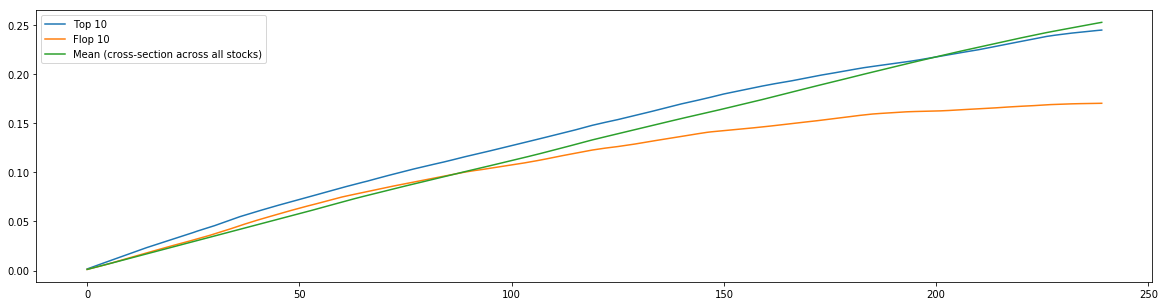

In [0]:
def detect_pattern_in_choie_of_LSTM_RNN(top_10_seq_array,flop_10_seq_array,num_study_period,data_directory="./train_trade_set/LSTM_RNN"):
    """
    Detect the pattern behind LSTM RNN's choice of top-k and flop-k stocks by cumulating the simple net daily return in the sequence until one day before
    trading and then averaging the cumulative return sequences of all top-k and flop-k stocks respectively. Moreover, same calculation is done for all
    available stocks' return sequence at each date.
    """
    # print(top_10_seq_array.shape)
    # print(flop_10_seq_array.shape)
    
    # calculate the cross section average of all top-k (or flop-k) stocks' cumulative simple net return sequences
    top_10_rtn_idx=np.mean(np.cumprod(top_10_seq_array+1,axis=1)-1,axis=0)
    flop_10_rtn_idx=np.mean(np.cumprod(flop_10_seq_array+1,axis=1)-1,axis=0)
    
    # calculate the cross section average of all available stocks' cumulative simple net return sequences
    trade_X_list=[]
    for study_period_idx in range(num_study_period):
        trade_X=pickle.load(open(data_directory+"/return_trade_X_"+str(study_period_idx),"rb"))  # the shape of trade_X is (num_instances,sequence_len)
        miu,sigma=pickle.load(open(data_directory+"/return_miu_sigma_"+str(study_period_idx),"rb"))
        trade_X_list.append(trade_X*sigma+miu)
    trade_X_array=np.concatenate(trade_X_list,axis=0)
    all_stock_rtn_idx=np.mean(np.cumprod(trade_X_array+1,axis=1)-1,axis=0)
    
    # plot the cumulative simple net return index of top-k, flop-k and all stocks
    plt.figure(figsize=(20,5))
    plt.plot(top_10_rtn_idx,label="Top 10")
    plt.plot(flop_10_rtn_idx,label="Flop 10")
    plt.plot(all_stock_rtn_idx,label="Mean (cross-section across all stocks)")
    plt.legend()
    
detect_pattern_in_choie_of_LSTM_RNN(top_k_seq,flop_k_seq,num_study_period)